In [23]:
import numpy as np

class RBM:
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden

        # Initialize weights
        self.weights = np.random.normal(scale=0.1, size=(num_visible, num_hidden))
        self.visible_bias = np.zeros(num_visible)
        self.hidden_bias = np.zeros(num_hidden)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def train(self, data, num_epochs=10, learning_rate=0.1):
        num_samples = data.shape[0]

        for epoch in range(num_epochs):
            # Positive phase
            hidden_prob = self._sigmoid(np.dot(data, self.weights) + self.hidden_bias)
            hidden_state = self._sample(hidden_prob)

            # Negative phase
            visible_recon_prob = self._sigmoid(np.dot(hidden_state, self.weights.T) + self.visible_bias)
            visible_recon_state = self._sample(visible_recon_prob)
            hidden_recon_prob = self._sigmoid(np.dot(visible_recon_state, self.weights) + self.hidden_bias)

            # Update weights
            positive_associations = np.dot(data.T, hidden_prob)
            negative_associations = np.dot(visible_recon_state.T, hidden_recon_prob)
            self.weights += learning_rate * (positive_associations - negative_associations) / num_samples
            self.visible_bias += learning_rate * (np.sum(data - visible_recon_state, axis=0)) / num_samples
            self.hidden_bias += learning_rate * (np.sum(hidden_prob - hidden_recon_prob, axis=0)) / num_samples

    def _sample(self, prob):
        return (np.random.random(size=prob.shape) < prob).astype(np.float32)
    
    def generate_sequence(self, initial_state, num_steps):
        state = initial_state
        sequence = []

        for step in range(num_steps):
            # Compute hidden units
            hidden_prob = self._sigmoid(np.dot(state, self.weights) + self.hidden_bias)
            hidden_state = self._sample(hidden_prob)

            # Compute visible units
            visible_prob = self._sigmoid(np.dot(hidden_state, self.weights.T) + self.visible_bias)
            state = self._sample(visible_prob)

            sequence.append(state)

        return np.array(sequence)
    
    def _sample_hidden(self, visible):
        hidden_activations = np.dot(visible, self.weights) + self.hidden_bias
        hidden_prob = self._sigmoid(hidden_activations)
        return self._sample(hidden_prob)

    def _sample_visible(self, hidden):
        visible_activations = np.dot(hidden, self.weights.T) + self.visible_bias
        visible_prob = self._sigmoid(visible_activations)
        return self._sample(visible_prob)

    def to_spin(self, prob):
        return np.where(np.random.random(size=prob.shape) < prob, 1, -1)


In [23]:
# save the RBM to a file

# Training

Fix a temperature, generate configurations at this temperature. Don't need to feed in temperature as label for rbm training since RBM is an unsupervised learning method, but for a conditional RBM could feed in the temperature label

In [11]:
rbm_data = np.load('rbm_data.npy')

In [12]:
# Assume that each sample in your data is a 1D array of spins
# representing a 2D lattice. This assumes a "flattening" of the 2D lattice.
num_visible = rbm_data.shape[1]  # Number of spins
num_hidden = 100  # This is a hyperparameter I you can tune

# Instantiate the RBM
rbm = RBM(num_visible=num_visible, num_hidden=num_hidden)

# Train the RBM
rbm.train(rbm_data, num_epochs=100, learning_rate=0.1)


In [26]:
# save the RBM to a file

import pickle

with open('trained_rbm.pkl', 'wb') as f:
    pickle.dump(rbm, f)

# Training Multiple RBMs

In [24]:
# Assume rbm_data is a list of data sets, one for each temperature
rbm_data = np.load('rbm_data2.npy')
# Create a list to hold the RBMs
rbms = []

# Train an RBM for each data set
for data in rbm_data:
    # Create the RBM
    rbm = RBM(num_visible=data.shape[1], num_hidden=5)  # or however many hidden units I want

    # Train the RBM
    rbm.train(data, num_epochs=100, learning_rate=0.1)

    # Add the trained RBM to the list
    rbms.append(rbm)


In [25]:
rbms

In [6]:
rbm_data

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [0, 1, 1, ..., 0, 1, 1],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1],
        [1, 0, 0, ..., 0, 1, 1]],

       [[1, 1, 1, ..., 1, 0, 1],
        [0, 0, 1, ..., 1, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 1, 1],
   

# Generating sequences of configurations from the RBM

In [53]:
with open('initial_configs.pickle', 'rb') as f:
    initial_configs = pickle.load(f)


In [54]:
# this code applies the forward and backward passes repeatedly for each of the rbms


with open('initial_configs.pickle', 'rb') as f:
    initial_configurations = pickle.load(f)

# Number of steps in the sequence for each RBM
sequence_length = 1000

# List to store the sequences for all RBMs
all_sequences = []

# For each RBM
for rbm, initial_visible in zip(rbms, initial_configurations):

    # Initialize a list to store the sequence for this RBM
    sequence = []

    # Start from the initial configuration
    visible = initial_visible

    # Generate the sequence
    for _ in range(sequence_length):
        # Forward pass (visible to hidden)
        hidden = rbm._sample_hidden(visible)

        # Backward pass (hidden to visible)
        new_visible_prob = rbm._sample_visible(hidden)

        # Convert probabilities to spin values
        new_visible = rbm.to_spin(new_visible_prob)

        # Append to the sequence
        sequence.append(new_visible)

        # Update the current visible configuration
        visible = new_visible

    # Append the sequence for this RBM to the list of all sequences
    all_sequences.append(sequence)


In [55]:
def calculate_magnetization(configuration):
    return np.mean(configuration)

In [56]:
def theoretical_magnetization(T):
    if T < 2 / np.log(1 + np.sqrt(2)):
        return (1 - np.sinh(2 / T) ** (-4)) ** (1 / 8)
    else:
        return 0

In [57]:
# Define a range of temperatures
temperatures = np.linspace(1.0, 3.0, num=1000)

# Initialize a list to store the effective temperatures for each configuration
effective_temperatures = []

# For each configuration in the sequence
for config in sequence:
    # Calculate the magnetization of the configuration
    config_magnetization = calculate_magnetization(config)

    # Calculate the theoretical magnetization for each temperature
    theoretical_magnetizations = np.array([theoretical_magnetization(T) for T in temperatures])

    # Find the temperature that gives the closest match to the configuration's magnetization
    effective_temperature = temperatures[np.argmin(np.abs(theoretical_magnetizations - config_magnetization))]

    # Append to the list of effective temperatures
    effective_temperatures.append(effective_temperature)

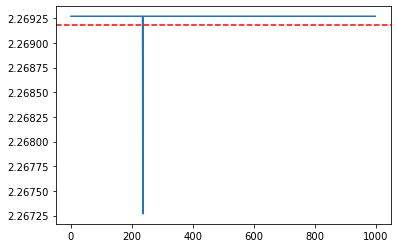

In [66]:
import matplotlib.pyplot as plt

plt.plot(effective_temperatures)
plt.axhline(y=2 / np.log(1 + np.sqrt(2)), color='r', linestyle='--')  # Critical temperature
plt.show()

# Testing

In [13]:
# Generate new samples

In [16]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [17]:
h = np.random.randint(0, 2, size=(num_hidden,))
for _ in range(1000):  # perform Gibbs sampling for some iterations
    probs = sigmoid(np.dot(h, rbm.weights) + rbm.visible_bias)
    v = np.random.binomial(1, probs)
    probs = sigmoid(np.dot(v, rbm.weights.T) + rbm.hidden_bias)
    h = np.random.binomial(1, probs)


In [18]:
# calculate free energy of visible state

In [20]:
def free_energy(v, rbm):
    v = v[np.newaxis]  # make sure v is a 2D array
    h = np.dot(v, rbm.weights.T) + rbm.hidden_bias
    return - np.dot(v, rbm.visible_bias.T) - np.sum(np.logaddexp(0, h))

# usage:
v = rbm_data[0]
F = free_energy(v, rbm)


In [21]:
print('Free energy of the given visible state is', F)

Free energy of the given visible state is [-47.43255957]


In [22]:
for i in range(len(rbm_data)):
    v = rbm_data[i]
    F = free_energy(v, rbm)
    print(f'Free energy of visible state {i} is {F}')


Free energy of visible state 0 is [-47.43255957]
Free energy of visible state 1 is [-82.76340173]
Free energy of visible state 2 is [-73.18559936]
Free energy of visible state 3 is [-88.87490441]
Free energy of visible state 4 is [-71.73459498]
Free energy of visible state 5 is [-64.9588089]
Free energy of visible state 6 is [-67.37675049]
Free energy of visible state 7 is [-74.77198906]
Free energy of visible state 8 is [-67.10966467]
Free energy of visible state 9 is [-62.76493416]
Free energy of visible state 10 is [-85.57131046]
Free energy of visible state 11 is [-62.43077898]
Free energy of visible state 12 is [-43.51069417]
Free energy of visible state 13 is [10.93693946]
Free energy of visible state 14 is [7.85640428]
Free energy of visible state 15 is [8.87215492]
Free energy of visible state 16 is [10.94501799]
Free energy of visible state 17 is [10.91088535]
Free energy of visible state 18 is [1.58626772]
Free energy of visible state 19 is [10.20858335]
Free energy of visibl

Free energy of visible state 431 is [-84.95038894]
Free energy of visible state 432 is [-82.82889292]
Free energy of visible state 433 is [-70.40316539]
Free energy of visible state 434 is [-2.53835634]
Free energy of visible state 435 is [7.31389491]
Free energy of visible state 436 is [10.87968981]
Free energy of visible state 437 is [3.7227089]
Free energy of visible state 438 is [-5.4037096]
Free energy of visible state 439 is [10.43759976]
Free energy of visible state 440 is [6.30622248]
Free energy of visible state 441 is [6.16756361]
Free energy of visible state 442 is [-47.58563537]
Free energy of visible state 443 is [-79.6978499]
Free energy of visible state 444 is [-82.29463832]
Free energy of visible state 445 is [-48.58588779]
Free energy of visible state 446 is [-84.96814352]
Free energy of visible state 447 is [-47.31679499]
Free energy of visible state 448 is [-61.79236598]
Free energy of visible state 449 is [-37.49908732]
Free energy of visible state 450 is [-46.91472

Free energy of visible state 1075 is [-58.17555934]
Free energy of visible state 1076 is [-81.93695436]
Free energy of visible state 1077 is [-37.24772907]
Free energy of visible state 1078 is [-78.09553562]
Free energy of visible state 1079 is [10.94246336]
Free energy of visible state 1080 is [10.02064048]
Free energy of visible state 1081 is [8.88929322]
Free energy of visible state 1082 is [11.00011561]
Free energy of visible state 1083 is [10.33970515]
Free energy of visible state 1084 is [10.88644737]
Free energy of visible state 1085 is [6.16466137]
Free energy of visible state 1086 is [8.20175334]
Free energy of visible state 1087 is [7.07677838]
Free energy of visible state 1088 is [8.97031881]
Free energy of visible state 1089 is [10.39552166]
Free energy of visible state 1090 is [9.56428304]
Free energy of visible state 1091 is [10.47623993]
Free energy of visible state 1092 is [-3.99338372]
Free energy of visible state 1093 is [-5.00935768]
Free energy of visible state 1094

Free energy of visible state 1394 is [9.8131506]
Free energy of visible state 1395 is [3.8182084]
Free energy of visible state 1396 is [10.92032527]
Free energy of visible state 1397 is [-16.0604352]
Free energy of visible state 1398 is [-75.45919298]
Free energy of visible state 1399 is [-45.3735217]
Free energy of visible state 1400 is [-48.02591152]
Free energy of visible state 1401 is [-66.25428162]
Free energy of visible state 1402 is [-80.05447657]
Free energy of visible state 1403 is [-80.17841924]
Free energy of visible state 1404 is [-83.76441658]
Free energy of visible state 1405 is [-23.5868777]
Free energy of visible state 1406 is [-92.19992208]
Free energy of visible state 1407 is [-59.73733721]
Free energy of visible state 1408 is [-52.30662477]
Free energy of visible state 1409 is [-82.19257708]
Free energy of visible state 1410 is [-15.208599]
Free energy of visible state 1411 is [-65.5267477]
Free energy of visible state 1412 is [-80.42580569]
Free energy of visible st

Free energy of visible state 1745 is [2.06884741]
Free energy of visible state 1746 is [3.56301933]
Free energy of visible state 1747 is [10.40062586]
Free energy of visible state 1748 is [7.98091157]
Free energy of visible state 1749 is [6.39928079]
Free energy of visible state 1750 is [11.39466403]
Free energy of visible state 1751 is [6.12513763]
Free energy of visible state 1752 is [-21.31033806]
Free energy of visible state 1753 is [5.22269949]
Free energy of visible state 1754 is [-5.95851703]
Free energy of visible state 1755 is [10.03822471]
Free energy of visible state 1756 is [9.4763916]
Free energy of visible state 1757 is [10.45453265]
Free energy of visible state 1758 is [-70.86107002]
Free energy of visible state 1759 is [-63.87505788]
Free energy of visible state 1760 is [-22.99389346]
Free energy of visible state 1761 is [-83.19414203]
Free energy of visible state 1762 is [-89.47840306]
Free energy of visible state 1763 is [-75.95873171]
Free energy of visible state 176

Free energy of visible state 2065 is [9.94895318]
Free energy of visible state 2066 is [9.45138607]
Free energy of visible state 2067 is [-10.04022383]
Free energy of visible state 2068 is [10.9293426]
Free energy of visible state 2069 is [11.36888953]
Free energy of visible state 2070 is [11.42136217]
Free energy of visible state 2071 is [4.63692165]
Free energy of visible state 2072 is [9.9319522]
Free energy of visible state 2073 is [10.44523578]
Free energy of visible state 2074 is [10.43028054]
Free energy of visible state 2075 is [6.78896215]
Free energy of visible state 2076 is [-0.52525516]
Free energy of visible state 2077 is [10.47984129]
Free energy of visible state 2078 is [9.30686771]
Free energy of visible state 2079 is [5.35412806]
Free energy of visible state 2080 is [9.88819876]
Free energy of visible state 2081 is [4.40468832]
Free energy of visible state 2082 is [10.45397827]
Free energy of visible state 2083 is [11.38137818]
Free energy of visible state 2084 is [8.7

Free energy of visible state 2361 is [-97.20228313]
Free energy of visible state 2362 is [-70.11354952]
Free energy of visible state 2363 is [-77.91193933]
Free energy of visible state 2364 is [-88.87490441]
Free energy of visible state 2365 is [-63.36863486]
Free energy of visible state 2366 is [-55.26505027]
Free energy of visible state 2367 is [-80.49785788]
Free energy of visible state 2368 is [-84.4369449]
Free energy of visible state 2369 is [-44.98702104]
Free energy of visible state 2370 is [-82.47219135]
Free energy of visible state 2371 is [-40.69219263]
Free energy of visible state 2372 is [-56.72631171]
Free energy of visible state 2373 is [-29.40401204]
Free energy of visible state 2374 is [-69.04151688]
Free energy of visible state 2375 is [-10.07692049]
Free energy of visible state 2376 is [4.11230357]
Free energy of visible state 2377 is [10.46766008]
Free energy of visible state 2378 is [7.27778995]
Free energy of visible state 2379 is [6.05953158]
Free energy of visib

Free energy of visible state 2728 is [-58.82296744]
Free energy of visible state 2729 is [-69.09099221]
Free energy of visible state 2730 is [-34.09366377]
Free energy of visible state 2731 is [-17.66023628]
Free energy of visible state 2732 is [-87.29728737]
Free energy of visible state 2733 is [-11.71697448]
Free energy of visible state 2734 is [-32.76802505]
Free energy of visible state 2735 is [-5.48249966]
Free energy of visible state 2736 is [10.47655096]
Free energy of visible state 2737 is [10.36265602]
Free energy of visible state 2738 is [9.18657501]
Free energy of visible state 2739 is [4.30788437]
Free energy of visible state 2740 is [7.41181121]
Free energy of visible state 2741 is [7.99838898]
Free energy of visible state 2742 is [9.9480958]
Free energy of visible state 2743 is [10.48764905]
Free energy of visible state 2744 is [10.49645953]
Free energy of visible state 2745 is [10.49685255]
Free energy of visible state 2746 is [0.97249428]
Free energy of visible state 27

Free energy of visible state 2936 is [10.4516488]
Free energy of visible state 2937 is [11.83421124]
Free energy of visible state 2938 is [8.10389966]
Free energy of visible state 2939 is [-12.03374856]
Free energy of visible state 2940 is [-11.7569092]
Free energy of visible state 2941 is [8.81199744]
Free energy of visible state 2942 is [5.64759783]
Free energy of visible state 2943 is [6.65503822]
Free energy of visible state 2944 is [3.00282585]
Free energy of visible state 2945 is [9.02308588]
Free energy of visible state 2946 is [9.82488132]
Free energy of visible state 2947 is [10.02541804]
Free energy of visible state 2948 is [8.33818481]
Free energy of visible state 2949 is [10.37075532]
Free energy of visible state 2950 is [10.42087586]
Free energy of visible state 2951 is [8.01919898]
Free energy of visible state 2952 is [-76.38798249]
Free energy of visible state 2953 is [-73.6000044]
Free energy of visible state 2954 is [-66.49333118]
Free energy of visible state 2955 is [

Free energy of visible state 3345 is [7.91398034]
Free energy of visible state 3346 is [-48.05549037]
Free energy of visible state 3347 is [-62.47227507]
Free energy of visible state 3348 is [-73.58285301]
Free energy of visible state 3349 is [-68.29901419]
Free energy of visible state 3350 is [-56.01379504]
Free energy of visible state 3351 is [-53.41492027]
Free energy of visible state 3352 is [-72.88962663]
Free energy of visible state 3353 is [-92.34694739]
Free energy of visible state 3354 is [-71.51505531]
Free energy of visible state 3355 is [-55.1671593]
Free energy of visible state 3356 is [-29.5658692]
Free energy of visible state 3357 is [-86.81441415]
Free energy of visible state 3358 is [-77.81081611]
Free energy of visible state 3359 is [-53.52353853]
Free energy of visible state 3360 is [-66.46808252]
Free energy of visible state 3361 is [11.00051077]
Free energy of visible state 3362 is [0.38604818]
Free energy of visible state 3363 is [2.37020314]
Free energy of visibl

Free energy of visible state 3745 is [10.96316484]
Free energy of visible state 3746 is [8.93149461]
Free energy of visible state 3747 is [9.51382251]
Free energy of visible state 3748 is [7.86512919]
Free energy of visible state 3749 is [10.4598702]
Free energy of visible state 3750 is [7.99339578]
Free energy of visible state 3751 is [3.14584705]
Free energy of visible state 3752 is [9.47126247]
Free energy of visible state 3753 is [3.54718389]
Free energy of visible state 3754 is [6.59821938]
Free energy of visible state 3755 is [4.32871793]
Free energy of visible state 3756 is [5.90553998]
Free energy of visible state 3757 is [9.8432087]
Free energy of visible state 3758 is [-11.12587609]
Free energy of visible state 3759 is [7.75321863]
Free energy of visible state 3760 is [8.71886006]
Free energy of visible state 3761 is [8.8554223]
Free energy of visible state 3762 is [7.10616828]
Free energy of visible state 3763 is [-12.40050244]
Free energy of visible state 3764 is [10.010233

Free energy of visible state 4011 is [10.93304152]
Free energy of visible state 4012 is [10.02377526]
Free energy of visible state 4013 is [-23.02156599]
Free energy of visible state 4014 is [-71.90384452]
Free energy of visible state 4015 is [-74.03331659]
Free energy of visible state 4016 is [-59.63854675]
Free energy of visible state 4017 is [-62.74790203]
Free energy of visible state 4018 is [-68.78581747]
Free energy of visible state 4019 is [-71.41513702]
Free energy of visible state 4020 is [-37.83326887]
Free energy of visible state 4021 is [-63.434311]
Free energy of visible state 4022 is [-86.79383737]
Free energy of visible state 4023 is [7.90545251]
Free energy of visible state 4024 is [7.44912955]
Free energy of visible state 4025 is [2.19797184]
Free energy of visible state 4026 is [-86.81434456]
Free energy of visible state 4027 is [-81.9138245]
Free energy of visible state 4028 is [-29.33668802]
Free energy of visible state 4029 is [-81.60575102]
Free energy of visible 

Free energy of visible state 4344 is [-16.63530139]
Free energy of visible state 4345 is [-33.61620481]
Free energy of visible state 4346 is [-84.79025773]
Free energy of visible state 4347 is [-86.97162756]
Free energy of visible state 4348 is [-61.81128815]
Free energy of visible state 4349 is [-54.31384472]
Free energy of visible state 4350 is [-45.09059068]
Free energy of visible state 4351 is [-28.50657038]
Free energy of visible state 4352 is [-86.64662105]
Free energy of visible state 4353 is [-91.97666031]
Free energy of visible state 4354 is [-84.14578393]
Free energy of visible state 4355 is [-62.29520091]
Free energy of visible state 4356 is [2.99189939]
Free energy of visible state 4357 is [7.57946695]
Free energy of visible state 4358 is [7.7760463]
Free energy of visible state 4359 is [2.95305753]
Free energy of visible state 4360 is [10.8419478]
Free energy of visible state 4361 is [8.37360111]
Free energy of visible state 4362 is [7.00433727]
Free energy of visible stat

Free energy of visible state 4824 is [10.89162651]
Free energy of visible state 4825 is [11.37962066]
Free energy of visible state 4826 is [6.72912273]
Free energy of visible state 4827 is [11.41978268]
Free energy of visible state 4828 is [6.90617429]
Free energy of visible state 4829 is [6.26539149]
Free energy of visible state 4830 is [7.5505226]
Free energy of visible state 4831 is [9.08192456]
Free energy of visible state 4832 is [7.27104046]
Free energy of visible state 4833 is [10.46369911]
Free energy of visible state 4834 is [0.94665184]
Free energy of visible state 4835 is [10.45011773]
Free energy of visible state 4836 is [6.36510606]
Free energy of visible state 4837 is [9.58361003]
Free energy of visible state 4838 is [9.91958991]
Free energy of visible state 4839 is [-59.79748746]
Free energy of visible state 4840 is [-55.86011815]
Free energy of visible state 4841 is [-84.39657195]
Free energy of visible state 4842 is [-57.70488689]
Free energy of visible state 4843 is [

Free energy of visible state 5153 is [10.02466843]
Free energy of visible state 5154 is [10.483652]
Free energy of visible state 5155 is [5.81304423]
Free energy of visible state 5156 is [8.1902758]
Free energy of visible state 5157 is [5.75762582]
Free energy of visible state 5158 is [3.78200272]
Free energy of visible state 5159 is [10.82563406]
Free energy of visible state 5160 is [9.98873773]
Free energy of visible state 5161 is [8.29483023]
Free energy of visible state 5162 is [6.3791251]
Free energy of visible state 5163 is [-0.62400418]
Free energy of visible state 5164 is [4.71001587]
Free energy of visible state 5165 is [8.89193903]
Free energy of visible state 5166 is [8.49422334]
Free energy of visible state 5167 is [-5.30288976]
Free energy of visible state 5168 is [2.2027418]
Free energy of visible state 5169 is [9.53532213]
Free energy of visible state 5170 is [5.30849741]
Free energy of visible state 5171 is [9.50749353]
Free energy of visible state 5172 is [8.38136283]


Free energy of visible state 5584 is [9.92560608]
Free energy of visible state 5585 is [10.5106658]
Free energy of visible state 5586 is [5.59348302]
Free energy of visible state 5587 is [11.78787625]
Free energy of visible state 5588 is [9.89650784]
Free energy of visible state 5589 is [-0.74735507]
Free energy of visible state 5590 is [11.37958687]
Free energy of visible state 5591 is [9.09502865]
Free energy of visible state 5592 is [1.61314577]
Free energy of visible state 5593 is [-21.38340905]
Free energy of visible state 5594 is [3.38381837]
Free energy of visible state 5595 is [5.99257388]
Free energy of visible state 5596 is [-76.85067896]
Free energy of visible state 5597 is [-84.17840163]
Free energy of visible state 5598 is [-46.42461688]
Free energy of visible state 5599 is [-58.13184183]
Free energy of visible state 5600 is [-75.63082312]
Free energy of visible state 5601 is [-73.49832972]
Free energy of visible state 5602 is [-87.37332134]
Free energy of visible state 56

Free energy of visible state 5799 is [10.97026201]
Free energy of visible state 5800 is [10.90037418]
Free energy of visible state 5801 is [1.86314918]
Free energy of visible state 5802 is [9.05550578]
Free energy of visible state 5803 is [10.0153614]
Free energy of visible state 5804 is [9.96291909]
Free energy of visible state 5805 is [10.4457588]
Free energy of visible state 5806 is [9.60273593]
Free energy of visible state 5807 is [9.85512993]
Free energy of visible state 5808 is [-30.37388695]
Free energy of visible state 5809 is [3.57373694]
Free energy of visible state 5810 is [-1.79591089]
Free energy of visible state 5811 is [8.74461516]
Free energy of visible state 5812 is [8.99275501]
Free energy of visible state 5813 is [10.96740997]
Free energy of visible state 5814 is [8.2578925]
Free energy of visible state 5815 is [10.41394615]
Free energy of visible state 5816 is [11.3643908]
Free energy of visible state 5817 is [4.32679036]
Free energy of visible state 5818 is [9.8563

Free energy of visible state 6389 is [-79.44599706]
Free energy of visible state 6390 is [-57.62079552]
Free energy of visible state 6391 is [-61.09569548]
Free energy of visible state 6392 is [-37.86520126]
Free energy of visible state 6393 is [-71.58943754]
Free energy of visible state 6394 is [-45.37991876]
Free energy of visible state 6395 is [-50.33372096]
Free energy of visible state 6396 is [-88.87490441]
Free energy of visible state 6397 is [-93.34403817]
Free energy of visible state 6398 is [-69.1596757]
Free energy of visible state 6399 is [-83.34182164]
Free energy of visible state 6400 is [-71.48776754]
Free energy of visible state 6401 is [5.37903414]
Free energy of visible state 6402 is [5.09060952]
Free energy of visible state 6403 is [5.73088389]
Free energy of visible state 6404 is [10.02327156]
Free energy of visible state 6405 is [-39.090322]
Free energy of visible state 6406 is [10.96282261]
Free energy of visible state 6407 is [10.87310024]
Free energy of visible s

Free energy of visible state 6958 is [-69.26510553]
Free energy of visible state 6959 is [-82.10024389]
Free energy of visible state 6960 is [11.38241273]
Free energy of visible state 6961 is [11.39797352]
Free energy of visible state 6962 is [7.71622183]
Free energy of visible state 6963 is [10.49127111]
Free energy of visible state 6964 is [9.43011385]
Free energy of visible state 6965 is [8.04010091]
Free energy of visible state 6966 is [5.72659994]
Free energy of visible state 6967 is [-74.04623303]
Free energy of visible state 6968 is [11.35197706]
Free energy of visible state 6969 is [7.33894485]
Free energy of visible state 6970 is [8.72603765]
Free energy of visible state 6971 is [11.75544228]
Free energy of visible state 6972 is [-6.7979732]
Free energy of visible state 6973 is [9.62520074]
Free energy of visible state 6974 is [9.01378942]
Free energy of visible state 6975 is [10.96797545]
Free energy of visible state 6976 is [-5.13589209]
Free energy of visible state 6977 is 

Free energy of visible state 7340 is [4.20405457]
Free energy of visible state 7341 is [8.93637474]
Free energy of visible state 7342 is [8.30823874]
Free energy of visible state 7343 is [9.46993327]
Free energy of visible state 7344 is [8.42535032]
Free energy of visible state 7345 is [8.4185912]
Free energy of visible state 7346 is [8.46623493]
Free energy of visible state 7347 is [9.96562349]
Free energy of visible state 7348 is [8.82725122]
Free energy of visible state 7349 is [-47.63304816]
Free energy of visible state 7350 is [-31.26922698]
Free energy of visible state 7351 is [-71.43298748]
Free energy of visible state 7352 is [-78.89416789]
Free energy of visible state 7353 is [-25.90200901]
Free energy of visible state 7354 is [-91.52532835]
Free energy of visible state 7355 is [-72.89405254]
Free energy of visible state 7356 is [-61.1073741]
Free energy of visible state 7357 is [-66.07427335]
Free energy of visible state 7358 is [-42.26336971]
Free energy of visible state 735

Free energy of visible state 7757 is [7.73085705]
Free energy of visible state 7758 is [-18.52420574]
Free energy of visible state 7759 is [5.52232584]
Free energy of visible state 7760 is [10.14048544]
Free energy of visible state 7761 is [4.81361766]
Free energy of visible state 7762 is [10.95951728]
Free energy of visible state 7763 is [9.50905485]
Free energy of visible state 7764 is [8.28052652]
Free energy of visible state 7765 is [9.0498936]
Free energy of visible state 7766 is [6.44713154]
Free energy of visible state 7767 is [9.0785709]
Free energy of visible state 7768 is [6.79686852]
Free energy of visible state 7769 is [10.47500797]
Free energy of visible state 7770 is [7.45404515]
Free energy of visible state 7771 is [-8.70033714]
Free energy of visible state 7772 is [5.99902066]
Free energy of visible state 7773 is [9.33862325]
Free energy of visible state 7774 is [8.95963309]
Free energy of visible state 7775 is [8.81699095]
Free energy of visible state 7776 is [7.104510

Free energy of visible state 8242 is [2.2642435]
Free energy of visible state 8243 is [3.75522927]
Free energy of visible state 8244 is [-24.0331032]
Free energy of visible state 8245 is [-90.76923649]
Free energy of visible state 8246 is [10.47382081]
Free energy of visible state 8247 is [9.87348185]
Free energy of visible state 8248 is [6.28078308]
Free energy of visible state 8249 is [7.76054497]
Free energy of visible state 8250 is [10.02473455]
Free energy of visible state 8251 is [10.90785667]
Free energy of visible state 8252 is [7.76762706]
Free energy of visible state 8253 is [9.05957688]
Free energy of visible state 8254 is [3.93233588]
Free energy of visible state 8255 is [9.93360498]
Free energy of visible state 8256 is [11.43466779]
Free energy of visible state 8257 is [9.25163035]
Free energy of visible state 8258 is [10.48634486]
Free energy of visible state 8259 is [9.47253864]
Free energy of visible state 8260 is [11.34397996]
Free energy of visible state 8261 is [9.01

Free energy of visible state 8417 is [7.20565328]
Free energy of visible state 8418 is [-50.79052185]
Free energy of visible state 8419 is [-56.09666839]
Free energy of visible state 8420 is [11.82208554]
Free energy of visible state 8421 is [10.56938597]
Free energy of visible state 8422 is [6.06373832]
Free energy of visible state 8423 is [7.05736119]
Free energy of visible state 8424 is [4.98436889]
Free energy of visible state 8425 is [-46.10149514]
Free energy of visible state 8426 is [-48.90270095]
Free energy of visible state 8427 is [10.48477906]
Free energy of visible state 8428 is [11.3530574]
Free energy of visible state 8429 is [7.56436476]
Free energy of visible state 8430 is [9.90637249]
Free energy of visible state 8431 is [9.89317829]
Free energy of visible state 8432 is [-3.22980046]
Free energy of visible state 8433 is [10.41639866]
Free energy of visible state 8434 is [11.40723499]
Free energy of visible state 8435 is [4.44120812]
Free energy of visible state 8436 is

Free energy of visible state 8838 is [-79.96362968]
Free energy of visible state 8839 is [9.40445603]
Free energy of visible state 8840 is [9.83561967]
Free energy of visible state 8841 is [-18.5567688]
Free energy of visible state 8842 is [8.30666238]
Free energy of visible state 8843 is [9.91159487]
Free energy of visible state 8844 is [8.12361511]
Free energy of visible state 8845 is [9.48367528]
Free energy of visible state 8846 is [-80.19290076]
Free energy of visible state 8847 is [-64.22948168]
Free energy of visible state 8848 is [-91.76182515]
Free energy of visible state 8849 is [-55.32227697]
Free energy of visible state 8850 is [-38.86156639]
Free energy of visible state 8851 is [9.55156173]
Free energy of visible state 8852 is [10.98400482]
Free energy of visible state 8853 is [10.43610394]
Free energy of visible state 8854 is [11.82515101]
Free energy of visible state 8855 is [10.39734681]
Free energy of visible state 8856 is [3.68722235]
Free energy of visible state 8857

Free energy of visible state 9275 is [-91.66169393]
Free energy of visible state 9276 is [-34.18578592]
Free energy of visible state 9277 is [-31.91414509]
Free energy of visible state 9278 is [-84.17222116]
Free energy of visible state 9279 is [-86.74212892]
Free energy of visible state 9280 is [0.78031533]
Free energy of visible state 9281 is [7.51789568]
Free energy of visible state 9282 is [10.40925205]
Free energy of visible state 9283 is [7.18637643]
Free energy of visible state 9284 is [10.84410238]
Free energy of visible state 9285 is [9.91922585]
Free energy of visible state 9286 is [7.07599118]
Free energy of visible state 9287 is [9.8324112]
Free energy of visible state 9288 is [9.85795127]
Free energy of visible state 9289 is [8.74696291]
Free energy of visible state 9290 is [10.93477294]
Free energy of visible state 9291 is [9.37849746]
Free energy of visible state 9292 is [6.46481591]
Free energy of visible state 9293 is [10.47893222]
Free energy of visible state 9294 is 

Free energy of visible state 9891 is [-69.20662562]
Free energy of visible state 9892 is [-80.79856198]
Free energy of visible state 9893 is [-57.85093351]
Free energy of visible state 9894 is [-71.81115781]
Free energy of visible state 9895 is [-12.34255133]
Free energy of visible state 9896 is [11.36655263]
Free energy of visible state 9897 is [10.90842679]
Free energy of visible state 9898 is [-82.00575755]
Free energy of visible state 9899 is [2.75880837]
Free energy of visible state 9900 is [2.80947692]
Free energy of visible state 9901 is [9.44365137]
Free energy of visible state 9902 is [10.46241333]
Free energy of visible state 9903 is [6.42984799]
Free energy of visible state 9904 is [-11.14122323]
Free energy of visible state 9905 is [7.78349385]
Free energy of visible state 9906 is [11.81774687]
Free energy of visible state 9907 is [9.27805556]
Free energy of visible state 9908 is [10.49397876]
Free energy of visible state 9909 is [9.99056686]
Free energy of visible state 99